In [1]:
%matplotlib inline
import pandas as pd
import pylab, math
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.font_manager as fm
zhfont = fm.FontProperties(fname='msyh.ttf')
import re
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 选项
这是一个python的notebook，也可以根据自己的喜好选择R的。File->New Notebook中有选项

In [2]:
delay = pd.read_csv('video_process_delay.csv')
retain = pd.read_csv('user_retention.csv')

# A 基础分析
* 查看数据的前8行
* 查看数据的相关信息（列名、维度、缺失、统计信息）
* 平均每个用户看多少个video
* 每个用户看video个数的分布(画图)
* 用户看视频的个数和留存的关系（统计和画图）

In [3]:
# 查看数据的前8行
delay.head(8)

,user,video,delay
0,3,0,2275
1,3,1,839
2,5,2,119
3,6,3,70
4,9,4,66
5,10,5,198
6,11,6,348
7,12,7,93


In [4]:
retain.head(8)

,user,retain
0,0,1
1,1,1
2,2,0
3,3,1
4,4,1
5,5,0
6,6,0
7,7,1


In [5]:
# 查看数据的相关信息（列名、维度、缺失、统计信息）
print("delay columns:", delay.columns)
print("retain columns:", retain.columns)
print("delay shape", delay.shape)
print("retain shape", retain.shape)

delay columns: Index(['user', 'video', 'delay'], dtype='object')
retain columns: Index(['user', 'retain'], dtype='object')
delay shape (282801, 3)
retain shape (168936, 2)


In [6]:
delay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282801 entries, 0 to 282800
Data columns (total 3 columns):
user     282801 non-null int64
video    282801 non-null int64
delay    282801 non-null int64
dtypes: int64(3)
memory usage: 6.5 MB


In [7]:
delay.describe()

,user,video,delay
count,282801.000000,282801.000000,282801.000000
mean,88253.622151,141400.000000,505.997468
std,49080.766603,81637.761076,4272.765087
min,0.000000,0.000000,3.000000
25%,46107.000000,70700.000000,79.000000
50%,89574.000000,141400.000000,236.000000
75%,131667.000000,212100.000000,629.000000
max,168935.000000,282800.000000,857526.000000


In [8]:
retain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168936 entries, 0 to 168935
Data columns (total 2 columns):
user      168936 non-null int64
retain    168936 non-null int64
dtypes: int64(2)
memory usage: 2.6 MB


In [9]:
retain.describe()

,user,retain
count,168936.000000,168936.000000
mean,84467.500000,0.386910
std,48767.766875,0.487044
min,0.000000,0.000000
25%,42233.750000,0.000000
50%,84467.500000,0.000000
75%,126701.250000,1.000000
max,168935.000000,1.000000


In [10]:
# 平均每个用户看多少个video
delay['video'].size/len(delay['user'].unique())
#delay.groupby('user').count()['video'].mean()

1.6740126438414547

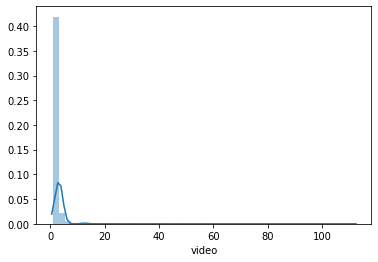

In [11]:
# 每个用户看video个数的分布(画图)
import numpy as np
#video_num = delay.groupby('user')['video'].agg(np.size)
video_num = delay.groupby('user').count()['video']
sns.distplot(video_num)

In [12]:
# 有异常值，我们取99%分位数看一下
video_num.quantile(0.99)

8.0

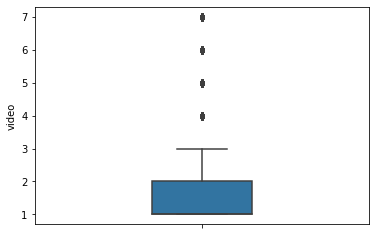

In [13]:
sns.boxplot(y=video_num[video_num<video_num.quantile(0.99)],width=0.3)

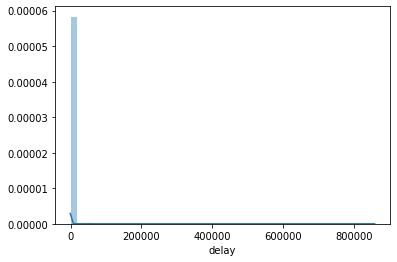

In [14]:
# 每个用户的平均延迟分布（画图）
delay_dis = delay.groupby('user')['delay'].agg(np.mean)
sns.distplot(delay_dis)

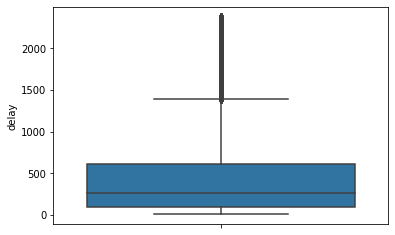

In [15]:
# 上图因为有异常值，分布被拉偏了，我们以99%分位数截断和重新作图
sns.boxplot(y=delay_dis[delay_dis<delay_dis.quantile(0.99)])

In [16]:
# 用户看视频的个数和留存的关系（b统计和画图）
user_video_num = delay.groupby('user')['video'].agg(np.size).to_frame().reset_index()
whole_df = pd.merge(retain, user_video_num, how='inner')
print("相关性为:", np.corrcoef(whole_df.video.values, whole_df.retain.values)[0,1])

相关性为: 0.17273025014150678


In [17]:
user_delay_mean = delay.groupby('user')['delay'].mean().to_frame().reset_index()
whole_df_d = pd.merge(retain, user_delay_mean, how='inner')
print("相关性为:", np.corrcoef(whole_df_d.delay.values, whole_df_d.retain.values)[0,1])

相关性为: 0.005313970547874938


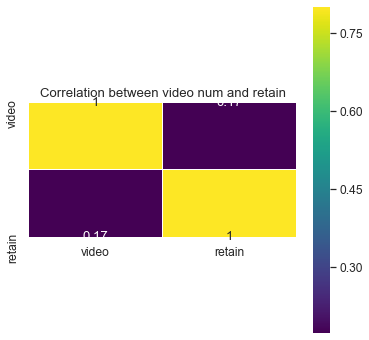

In [18]:
corrMatrix=whole_df[['video', 'retain']].corr()
sns.set(font_scale=1.10)
plt.figure(figsize=(6, 6))
sns.heatmap(corrMatrix, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='viridis',linecolor="white")
plt.title('Correlation between video num and retain');

# B. 基础分析，回答如下问题
* 平均留存率是多少
* 系统处理延迟(delay)的分布图。
* 对延迟按等频做100分桶，每个桶内有多少用户，同时作图表示一下分布
* 延迟的平均值，P50，P90，P95，P99分别是多少，是否可以用图表达
* 对延迟按照每100分桶，每个桶的作者留存率是多少？画图

(网上搜索“pandas 回归”等关键词可以找到很多教程，例如 http://lib.csdn.net/article/machinelearning/35051)

In [19]:
# 平均留存率
retain['retain'].mean()

0.3869098356774163

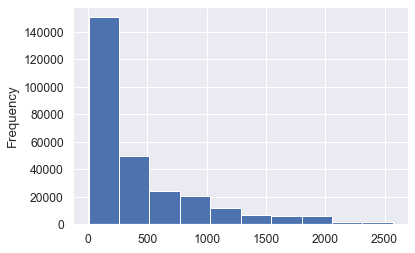

In [20]:
# 系统处理延迟（delay）的分布图

#### 数据同样有异常值，我们根据99%分位数做截断，再绘图
delay.loc[delay['delay']<delay['delay'].quantile(0.99),'delay'].plot(kind='hist')

In [21]:
# 对延迟按等频做100分桶，每个桶内有多少用户，同时作图表示一下分布
delay.loc[:,'bucket_qcut'] = pd.qcut(x=delay['delay'], q=100)
bucket_user_num = delay.groupby('bucket_qcut')['user'].nunique()

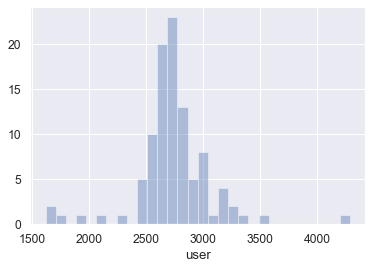

In [22]:
sns.distplot(bucket_user_num,kde=False)

In [23]:
# 延迟的平均值，P50，P90，P95，P99分别是多少，是否可以用图表达
print('mean', delay['delay'].mean())
delay['delay'].quantile([0.5,0.9,0.95,0.99])

mean 505.99746818434164


0.50     236.0
0.90    1205.0
0.95    1715.0
0.99    2571.0
Name: delay, dtype: float64

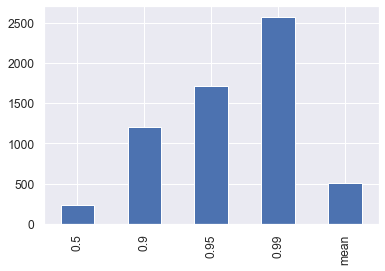

In [24]:
s = delay['delay'].quantile([0.5,0.9,0.95,0.99])
s['mean'] = delay['delay'].mean()
s.plot(kind='bar')

In [25]:
# 对延迟按照每100分桶，每个桶的作者留存率是多少？画图
merge_df = pd.merge(delay, retain, on='user', how='inner')
merge_df.loc[:,'bucket_cut'] = merge_df['delay']//100
merge_df

,user,video,delay,bucket_qcut,retain,bucket_cut
0,3,0,2275,"(2131.0, 2571.0]",1,22
1,3,1,839,"(819.0, 847.0]",1,8
2,5,2,119,"(114.0, 120.0]",0,1
3,6,3,70,"(69.0, 71.0]",0,0
4,9,4,66,"(65.0, 67.0]",0,0
5,10,5,198,"(193.0, 201.0]",0,1
6,11,6,348,"(344.0, 356.0]",0,3
7,12,7,93,"(91.0, 95.0]",1,0
8,17,8,55,"(54.0, 56.0]",1,0
9,17,9,41,"(39.0, 41.0]",1,0


In [26]:
bucket_cut_retain_dis = merge_df.groupby('bucket_cut')['retain'].mean()
bucket_cut_retain_dis

bucket_cut
0       0.482350
1       0.465559
2       0.453355
3       0.451978
4       0.470542
5       0.475194
6       0.466963
7       0.461520
8       0.477350
9       0.480811
10      0.461373
11      0.478187
12      0.485737
13      0.467423
14      0.487010
15      0.481175
16      0.456900
17      0.446313
18      0.480205
19      0.473756
20      0.516304
21      0.533333
22      0.496617
23      0.531835
24      0.503571
25      0.494424
26      0.572016
27      0.525151
28      0.569288
29      0.539623
          ...   
996     1.000000
1021    0.000000
1092    1.000000
1117    1.000000
1158    1.000000
1169    1.000000
1195    1.000000
1262    1.000000
1394    1.000000
1471    0.000000
1472    0.000000
1507    1.000000
1598    1.000000
1816    0.000000
1920    0.000000
2698    1.000000
2738    0.000000
2749    1.000000
3884    1.000000
4442    1.000000
4684    1.000000
4700    1.000000
4930    0.000000
5423    1.000000
5787    1.000000
5841    0.000000
6387    1.000000
781

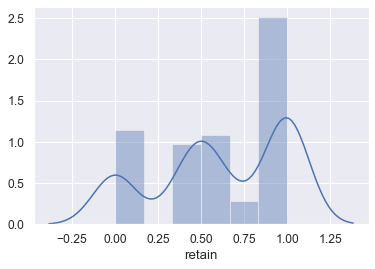

In [27]:
# 不同留存率分布图
sns.distplot(bucket_cut_retain_dis)

# C. 相关性分析
(提示，两张表的链接可以使用pandas的merge函数。在这个notebook里就是pd.merge。细节可以google)
1. 平均延迟每降低100，留存会提升或者降低多少？
2. 如果降低平均延迟，会改变留存吗？

In [28]:
bucket_cut_retain_dis.head()

bucket_cut
0    0.482350
1    0.465559
2    0.453355
3    0.451978
4    0.470542
Name: retain, dtype: float64

In [29]:
# 平均延迟每降低100，留存会提升或者降低多少？
bucket_cut_retain_dis.diff(-1).mean()

bucket_cut（shift  -1）-  bucket_cut

0.0022539732226941277

In [30]:
# 如果降低平均延迟，会改变留存吗？
print("会改变留存，留存率会变高")

会改变留存，留存率会变高


# D.拓展分析
请问从上述数据，你还可以分析出什么有用的信息吗？请自由发挥

In [31]:
# 其他分析
